# Euclidean Restricted Boltzman Machine for Wordnet Hierarchy Data

## Imports: nltk for wordnet data, as well as numpy, sklearn, and matplotlib

In [1]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet as wn
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import networkx as nx

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kylie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Extract animal subtree (animal.n.01 and all descendent synsets) from data

In [2]:
def get_hyponyms(synset):
    # Recursively get all hyponyms of a synset
    hyponyms = synset.hyponyms()
    all_hyponyms = set(hyponyms)
    for hypo in hyponyms:
        all_hyponyms = all_hyponyms.union(get_hyponyms(hypo))
    return all_hyponyms

# Select the root synset
root = wn.synset('mammal.n.01')
print(f"Direct hypernyms: {root.hypernyms()}")
print(f"\nDirect hyponyms: {root.hyponyms()}")
 
# Get all hyponyms in the root subtree
animal_hyponyms = get_hyponyms(root)
# Include the root itself.
animal_synsets = list(animal_hyponyms) + [root]

# For easier handling, sort the synsets by name
animal_synsets = sorted(animal_synsets, key=lambda s: s.name())
print(f"\nTotal number of synsets in the animal subtree: {len(animal_synsets)}")


Direct hypernyms: [Synset('vertebrate.n.01')]

Direct hyponyms: [Synset('female_mammal.n.01'), Synset('fossorial_mammal.n.01'), Synset('metatherian.n.01'), Synset('placental.n.01'), Synset('prototherian.n.01'), Synset('tusker.n.01')]

Total number of synsets in the animal subtree: 1170


## Create a binary feature matrix from the data
### Rows and columns represent synsets in our data, and a '1' marks a relationship between two synsets

In [3]:
# Create a mapping for synset to index
synset_to_index = {s: i for i, s in enumerate(animal_synsets)}
num_synsets = len(animal_synsets)

### For each synset, we extract its hypernym paths (union)

In [4]:
def synset_feature_vector(synset, synset_to_index):
    """Create a binary vector for a synset indicating the presence of itself and its ancestors in the subtree."""
    feature = np.zeros(len(synset_to_index))
    
    # Get all hypernym paths (each is a list from the synset to the root)
    hypernym_paths = synset.hypernym_paths()
    # Take the union of all synsets appearing in any hypernym path
    hypernyms = set()
    for path in hypernym_paths:
        hypernyms.update(path)
    # Intersect with subtree’s synsets (keys in our mapping)
    relevant_synsets = hypernyms.intersection(synset_to_index.keys())
    for rel in relevant_synsets:
        feature[synset_to_index[rel]] = 1
    return feature

# Build the dataset: each row is a synset's binary feature vector
data = np.array([synset_feature_vector(s, synset_to_index) for s in animal_synsets])
print("Shape of data matrix:", data.shape)

Shape of data matrix: (1170, 1170)


## Define and Train the RBM (scikit-learn's Bernoulli RBM)

In [5]:
# Define RBM parameters
n_components = 50 # Number of hidden units
learning_rate = 0.1
n_iter = 50 # Number of iterations over the training set

rbm = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
rbm.fit(data)

BernoulliRBM(n_components=50, n_iter=50, random_state=42)

## Looking at the learned weights

In [6]:
# View the weights of the first 5 hidden units
for i in range(5):
    weight_vector = rbm.components_[i]
    # Identify the top contributing synsets for this hidden unit
    top_indices = weight_vector.argsort()[-5:][::-1]
    top_synsets = [animal_synsets[j].name() for j in top_indices]
    print(f"Hidden Unit {i+1}: Top synsets -> {top_synsets}")

Hidden Unit 1: Top synsets -> ['mammal.n.01', 'placental.n.01', 'ungulate.n.01', 'equine.n.01', 'carnivore.n.01']
Hidden Unit 2: Top synsets -> ['mammal.n.01', 'placental.n.01', 'carnivore.n.01', 'even-toed_ungulate.n.01', 'ruminant.n.01']
Hidden Unit 3: Top synsets -> ['mammal.n.01', 'placental.n.01', 'equine.n.01', 'ruminant.n.01', 'odd-toed_ungulate.n.01']
Hidden Unit 4: Top synsets -> ['mammal.n.01', 'placental.n.01', 'bovid.n.01', 'even-toed_ungulate.n.01', 'ruminant.n.01']
Hidden Unit 5: Top synsets -> ['mammal.n.01', 'placental.n.01', 'carnivore.n.01', 'dog.n.01', 'ungulate.n.01']


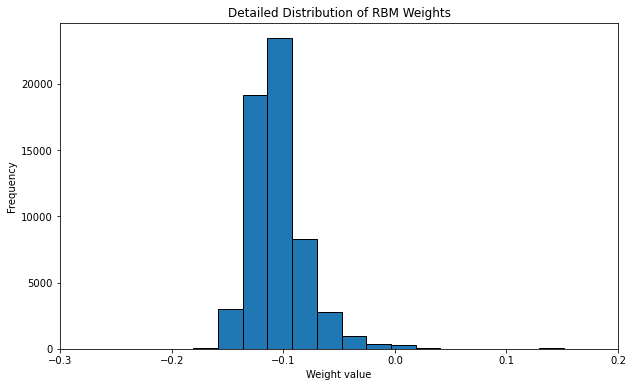

In [7]:
# Plot a more detailed histogram of the weights
plt.figure(figsize=(10, 6))
plt.hist(rbm.components_.ravel(), bins=200, edgecolor='black')
plt.title("Detailed Distribution of RBM Weights")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.xlim(-0.3, 0.2)
#plt.ylim(0,400)
plt.show()

## Reduce hidden nodes using PCA and visualize to see clustering/relationships

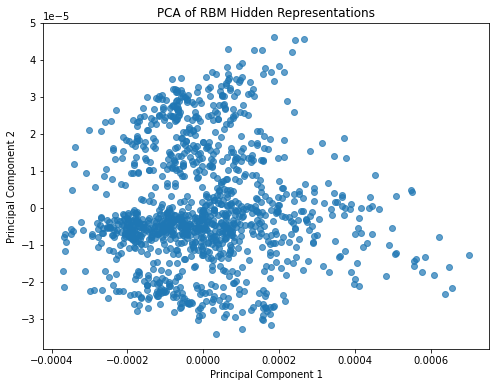

In [8]:
from sklearn.decomposition import PCA

# Get the hidden representations for all samples
hidden_reps = rbm.transform(data)

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(hidden_reps)

plt.figure(figsize=(8, 6))
plt.scatter(hidden_2d[:, 0], hidden_2d[:, 1], alpha=0.7)
plt.title("PCA of RBM Hidden Representations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Test RBM: How accurate is the reconstruction?

In [9]:
# Function for repeated gibbs sampling
def reconstruct(sample):
    steps = 5
    v = original_sample
    for _ in range(steps):
        v = rbm.gibbs(v)
    reconstructed_sample = v
    return reconstructed_sample

In [36]:
# Select a sample from the data
sample_idx = synset_to_index[wn.synset('dog.n.01')]
print(animal_synsets[sample_idx].name())
original_sample = data[sample_idx]

reconstructed_sample = reconstruct(original_sample)

dog.n.01


In [37]:
# Since the output is probabilities between 0 and 1, threshold them to decide activated nodes
threshold = 0.5
original_active = [animal_synsets[i].name() for i, v in enumerate(original_sample) if v == 1]
reconstructed_active = [animal_synsets[i].name() for i, v in enumerate(reconstructed_sample) if v >= threshold]

print("Chosen Sample Node: ")
print(animal_synsets[sample_idx].name())
print("\nOriginal active synsets:")
print(original_active)
print("\nReconstructed active synsets:")
print(reconstructed_active)

Chosen Sample Node: 
dog.n.01

Original active synsets:
['canine.n.02', 'carnivore.n.01', 'dog.n.01', 'mammal.n.01', 'placental.n.01']

Reconstructed active synsets:
['bovid.n.01', 'dog.n.01', 'mammal.n.01', 'odd-toed_ungulate.n.01', 'placental.n.01', 'primate.n.02', 'rabbit-eared_bandicoot.n.01']


In [38]:
# Calculate a simple reconstruction error metric
reconstruction_error = np.mean(np.abs(original_sample - reconstructed_sample))
print(f"\nReconstruction error (mean absolute difference): {reconstruction_error:.4f}")


Reconstruction error (mean absolute difference): 0.0051


In [39]:
# Calculate precision, recall, and F1
y_pred = reconstructed_sample.astype(int)
y_true = original_sample.astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='binary', zero_division=0
)
print(f"Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

Precision=0.429, Recall=0.600, F1=0.500


In [40]:
# Helper function: Given a set of synset objects, return an extended set
# that includes, for each synset, its immediate neighbors
def extend_active_set(active_synsets, synset_to_index):
    extended = set(active_synsets)  # Start with the direct active set
    for syn in active_synsets:
        # Get immediate hyponyms (children)
        for child in syn.hyponyms():
            if child in synset_to_index:  # only include if in subset
                extended.add(child)
        # Get immediate hypernyms (parents)
        for parent in syn.hypernyms():
            if parent in synset_to_index:  # only include if in subset
                extended.add(parent)
    return extended

# Create extended sets by including one more layer of neighbors
original_active = [animal_synsets[i] for i, v in enumerate(original_sample) if v == 1]
reconstructed_active = [animal_synsets[i] for i, v in enumerate(reconstructed_sample) if v >= threshold]

extended_active_original = extend_active_set(original_active, synset_to_index)
extended_active_recon = extend_active_set(reconstructed_active, synset_to_index)

# Convert the synset objects to their names for easy comparison and printing
original_active_names = [syn.name() for syn in extended_active_original]
reconstructed_active_names = [syn.name() for syn in extended_active_recon]

print("Extended original active synsets (direct + one extra layer):")
print(original_active_names)

print("\nExtended reconstructed active synsets (direct + one extra layer):")
print(reconstructed_active_names)

Extended original active synsets (direct + one extra layer):
['ungulate.n.01', 'metatherian.n.01', 'lagomorph.n.01', 'flying_lemur.n.01', 'female_mammal.n.01', 'toy_dog.n.01', 'hunting_dog.n.01', 'feline.n.01', 'hyena.n.01', 'canine.n.02', 'rodent.n.01', 'dalmatian.n.02', 'insectivore.n.01', 'wild_dog.n.01', 'jackal.n.01', 'bull.n.11', 'ungulata.n.01', 'buck.n.05', 'wolf.n.01', 'working_dog.n.01', 'mexican_hairless.n.01', 'poodle.n.01', 'unguiculata.n.01', 'yearling.n.03', 'bitch.n.04', 'livestock.n.01', 'lapdog.n.01', 'pangolin.n.01', 'digitigrade_mammal.n.01', 'tree_shrew.n.01', 'placental.n.01', 'leonberg.n.01', 'puppy.n.01', 'aquatic_mammal.n.01', 'dog.n.01', 'musteline_mammal.n.01', 'great_pyrenees.n.01', 'griffon.n.02', 'aardvark.n.01', 'edentate.n.01', 'prototherian.n.01', 'spitz.n.01', 'hyrax.n.01', 'fossorial_mammal.n.01', 'proboscidean.n.01', 'cow.n.02', 'plantigrade_mammal.n.01', 'carnivore.n.01', 'fox.n.01', 'basenji.n.01', 'newfoundland.n.01', 'fissiped_mammal.n.01', 'mamm

## Hierarchical Tree Graph

In [41]:
orig_set = set(original_active_names)
recon_set = set(reconstructed_active_names)

In [42]:
# Build full graph
G = nx.DiGraph()
for s in animal_synsets:
    name = s.name()
    G.add_node(name)
    for parent in s.hypernyms():
        if parent in synset_to_index:
            G.add_edge(parent.name(), name)
            
# Subgraph of active nodes
active_union = orig_set.union(recon_set)
H = G.subgraph(active_union).copy()

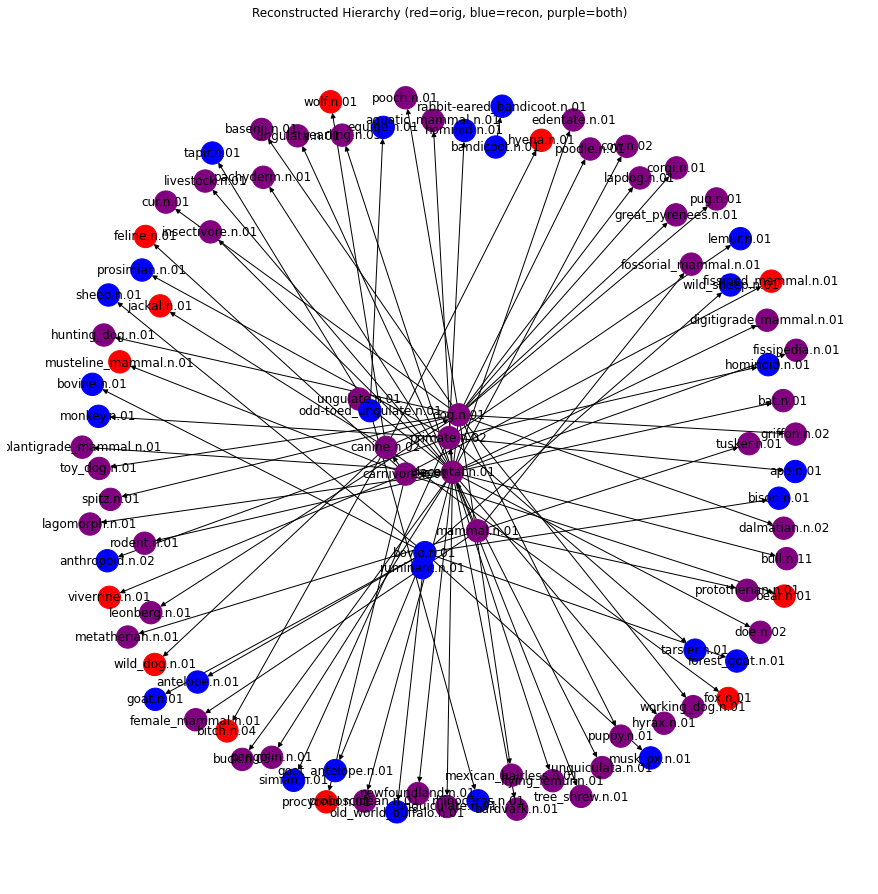

In [43]:
# Color nodes
color_map = []
for node in H.nodes():
    if node in orig_set and node in recon_set:
        color_map.append('purple')
    elif node in orig_set:
        color_map.append('red')
    else:
        color_map.append('blue')

# Layout and draw
try:
    pos = nx.nx_agraph.graphviz_layout(H, prog='dot')
except:
    pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=True, node_color=color_map,
        node_size=500, arrows=True)
plt.title('Reconstructed Hierarchy (red=orig, blue=recon, purple=both)')
plt.show()

# Now the hard part: Hyperbolic RBM

In [19]:
from tqdm import tqdm  # Import tqdm for progress tracking

## Class for hyperbolic number algebra

In [20]:
class HyperbolicNumber:
    def __init__(self, a, b=0.0):
        # Initialize a hyperbolic number with real part a and imaginary part b
        self.a = float(a)
        self.b = float(b)
        
    def __add__(self, other):
        # Define the addition operator
        if isinstance(other, HyperbolicNumber):
            # If adding two hyperbolic numbers, add real parts and imaginary parts
            return HyperbolicNumber(self.a + other.a, self.b + other.b)
        else:
            # If adding a real number, add it only to the real part
            return HyperbolicNumber(self.a + other, self.b)
    __radd__ = __add__  # For commutative addition
    
    def __sub__(self, other):
        # Define the subtraction operator
        if isinstance(other, HyperbolicNumber):
            return HyperbolicNumber(self.a - other.a, self.b - other.b)
        else:
            return HyperbolicNumber(self.a - other, self.b)
    
    def __mul__(self, other):
        # Define the multiplication operator
        # For hyperbolic numbers: (a + bj) * (c + dj) = (ac + bd) + (ad + bc)j
        if isinstance(other, HyperbolicNumber):
            real = self.a * other.a + self.b * other.b
            imag = self.a * other.b + self.b * other.a
            return HyperbolicNumber(real, imag)
        else:
            # Multiplication by a scalar multiplies both parts
            return HyperbolicNumber(self.a * other, self.b * other)
    __rmul__ = __mul__
    
    def exp(self):
        # Exponential function: exp(a + bj) = exp(a) * (cosh(b) + j * sinh(b))
        exp_a = np.exp(self.a)
        return HyperbolicNumber(exp_a * np.cosh(self.b), exp_a * np.sinh(self.b))
    
    def __str__(self):
        # String representation for easy printing
        return f"{self.a} + {self.b}j"
    
    def __repr__(self):
        return self.__str__()
    
    def copy(self):
        # Return a copy of the hyperbolic number
        return HyperbolicNumber(self.a, self.b)

## Activation Function

In [21]:
def hyperbolic_sigmoid(hn):
    # A simple hyperbolic sigmoid function
    # Takes a HyperbolicNumber (hn) and applies the standard sigmoid to its real part
    # Returns a new HyperbolicNumber whose real part is the sigmoid value, and the imaginary part is zero
    sig = 1 / (1 + np.exp(-hn.a))   # Standard logistic sigmoid on the real part
    return HyperbolicNumber(sig, 0.0)


## Hyperbolic RBM mimics regular RBM but with hyperbolic weights and biases

In [22]:
class HyperbolicRBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, n_iter=10):
        # Initialize the HRBM with the number of visible and hidden units,
        # plus training parameters such as learning rate and number of iterations
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        
        # Initialize weight matrix W: a 2D array (n_hidden x n_visible) of hyperbolic numbers
        # We use small random values for both the real and imaginary parts
        self.W = np.array([
            [HyperbolicNumber(np.random.normal(0, 0.01), np.random.normal(0, 0.01))
             for j in range(n_visible)]
            for i in range(n_hidden)
        ])
                             
        # Initialize hidden biases (one per hidden unit) as hyperbolic numbers set to 0
        self.h_bias = np.array([HyperbolicNumber(0.0, 0.0) for _ in range(n_hidden)])
        
        # Initialize visible biases (one per visible unit) as hyperbolic numbers set to 0
        self.v_bias = np.array([HyperbolicNumber(0.0, 0.0) for _ in range(n_visible)])
        
    def _compute_hidden_prob(self, v):
        # Compute hidden unit activation probabilities given a visible data vector v
    
        h_probs = []  # List to store activation probabilities for each hidden unit
        for i in range(self.n_hidden):
            total = HyperbolicNumber(0.0, 0.0)  # Start with zero for each hidden unit
            for j in range(self.n_visible):
                # Multiply the hyperbolic weight with the binary visible input and add to the total
                total += self.W[i][j] * v[j]
            total += self.h_bias[i]  # Add hidden bias for unit i
            # Apply the hyperbolic sigmoid activation function
            h_probs.append(hyperbolic_sigmoid(total))
        return h_probs  # Returns a list of HyperbolicNumber objects
    
    def _compute_visible_prob(self, h):
        # Compute visible unit activation probabilities given a hidden data vector h
        
        v_probs = []  # List to store computed probabilities for each visible unit
        for j in range(self.n_visible):
            total = HyperbolicNumber(0.0, 0.0)  # Start with zero for each visible unit
            for i in range(self.n_hidden):
                total += self.W[i][j] * h[i]
            total += self.v_bias[j]  # Add visible bias for unit j
            # Apply activation and use the real part as the probability
            act = hyperbolic_sigmoid(total)
            v_probs.append(act.a)
        return np.array(v_probs)
    
    def gibbs_sample(self, v0):
        # Perform one step of Gibbs sampling starting from a visible vector v0
        
        # Compute hidden activation probabilities
        h_probs = self._compute_hidden_prob(v0)
        # Sample hidden states: if the real part > random threshold then activate 1, else 0
        h_states = np.array([1 if prob.a > np.random.rand() else 0 for prob in h_probs])
        
        # Compute visible unit activation probabilities from the hidden states
        v_probs = self._compute_visible_prob(h_states)
        # Sample visible states in a similar way
        v_states = np.array([1 if p > np.random.rand() else 0 for p in v_probs])
        return v_states
    
    def fit(self, data):
        # Train the Hyperbolic RBM on the provided binary data matrix using a simplified version of Contrastive Divergence (CD-1)
    
        n_samples = data.shape[0]
        
        for epoch in range(self.n_iter):
            # Wrap the inner loop with tqdm to display a progress bar for this epoch
            for sample in tqdm(data, desc=f"Epoch {epoch+1}/{self.n_iter}", unit="sample"):
                # Positive phase: compute hidden unit probabilities from the original sample
                h_probs = self._compute_hidden_prob(sample)
                # Sample binary hidden states from these probabilities
                h_states = np.array([1 if prob.a > np.random.rand() else 0 for prob in h_probs])
                
                # Negative phase: reconstruct visible units by running Gibbs sampling
                v_reconstructed = self.gibbs_sample(sample)
                # Compute hidden probabilities from the reconstructed visible vector
                h_probs_neg = self._compute_hidden_prob(v_reconstructed)
                
                # Update weights and biases based on the difference (contrastive divergence)
                for i in range(self.n_hidden):
                    for j in range(self.n_visible):
                        # Positive association: product of hidden probability (real part) and visible unit activation
                        pos = h_probs[i].a * sample[j]
                        # Negative association: product of hidden probability (from negative phase) and reconstructed visible
                        neg = h_probs_neg[i].a * v_reconstructed[j]
                        # Compute the update (delta) using the difference scaled by the learning rate
                        delta = self.learning_rate * (pos - neg)
                        # Update only the real part of the weight (for simplicity)
                        self.W[i][j].a += delta
                        # self.W[i][j].b += self.learning_rate * (h_probs[i].b * sample[j] - h_probs_neg[i].b * v_reconstructed[j])
                
                # Update hidden biases (only updating the real part)
                for i in range(self.n_hidden):
                    delta = self.learning_rate * (h_probs[i].a - h_probs_neg[i].a)
                    self.h_bias[i].a += delta
                
                # Update visible biases
                for j in range(self.n_visible):
                    delta = self.learning_rate * (sample[j] - v_reconstructed[j])
                    self.v_bias[j].a += delta
            
            print(f"Epoch {epoch + 1} complete")


## Training the HRBM

In [23]:
n_visible = data.shape[1]  # number of features (synsets)
n_hidden = 50              # number of hidden units

# Create an instance of the HyperbolicRBM
hrbm = HyperbolicRBM(n_visible, n_hidden, learning_rate=0.1, n_iter=3)

# Train the HRBM on the binary data matrix
hrbm.fit(data)

Epoch 1/3: 100%|███████████████████████████████████████████████████████████████| 1170/1170 [19:49<00:00,  1.02s/sample]


Epoch 1 complete


Epoch 2/3: 100%|███████████████████████████████████████████████████████████████| 1170/1170 [18:11<00:00,  1.07sample/s]


Epoch 2 complete


Epoch 3/3: 100%|███████████████████████████████████████████████████████████████| 1170/1170 [18:30<00:00,  1.05sample/s]

Epoch 3 complete


In [56]:
# Retrieve the synset
pug_synset = wn.synset('pug.n.01')

# Check if pug.n.01 exists in the subset
if pug_synset in synset_to_index:
    # Get the index for pug.n.01 in your animal_synsets list
    pug_index = synset_to_index[pug_synset]
    print("Chosen Sample Node: ")
    print(animal_synsets[pug_index].name())
    
    # Extract the binary feature vector (1D) for this synset
    test_sample = data[pug_index]
    
    # Use the Hyperbolic RBM to perform one Gibbs sampling step and reconstruct the visible vector
    hrbm_reconstruction = hrbm.gibbs_sample(test_sample)
    
    # Interpret the results by converting the active indices to synset names
    # For the original sample, a value of 1 means the synset is active
    original_active = [animal_synsets[i].name() for i, v in enumerate(test_sample) if v == 1]
    
    # For the reconstruction, use a threshold since the values may not be exactly binary
    threshold = 0.5
    reconstructed_active = [animal_synsets[i].name() for i, v in enumerate(hrbm_reconstruction) if v >= threshold]
    
    print("\nOriginal active synsets:")
    print(original_active)
    
    print("\nReconstructed active synsets:")
    print(reconstructed_active)
    
else:
    print("'pug.n.01' is not included in your current WordNet subset (animal_synsets).")

Chosen Sample Node: 
pug.n.01

Original active synsets:
['canine.n.02', 'carnivore.n.01', 'dog.n.01', 'mammal.n.01', 'placental.n.01', 'pug.n.01']

Reconstructed active synsets:
['canine.n.02', 'carnivore.n.01', 'dog.n.01', 'mammal.n.01', 'phyllostomus_hastatus.n.01', 'placental.n.01']


In [57]:
# Calculate a simple reconstruction error metric
reconstruction_error = np.mean(np.abs(test_sample - hrbm_reconstruction))
print(f"\nReconstruction error (mean absolute difference): {reconstruction_error:.4f}")


Reconstruction error (mean absolute difference): 0.0017


In [58]:
# Calculate precision, recall, and F1
y_pred = hrbm_reconstruction.astype(int)
y_true = test_sample.astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='binary', zero_division=0
)
print(f"Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

Precision=0.833, Recall=0.833, F1=0.833


## What if we attempt to reconstruct more than one layer?

In [59]:
# Extract the directly active nodes from the original sample
direct_active_original = [animal_synsets[i] for i, v in enumerate(test_sample) if v == 1]

# For the reconstruction, use a threshold (since values may not be exactly binary)
threshold = 0.1
direct_active_recon = [animal_synsets[i] for i, v in enumerate(hrbm_reconstruction) if v >= threshold]

# Helper function: Given a set of synset objects, return an extended set
# that includes, for each synset, its immediate neighbors
def extend_active_set(active_synsets, synset_to_index):
    extended = set(active_synsets)  # Start with the direct active set
    for syn in active_synsets:
        # Get immediate hyponyms (children)
        for child in syn.hyponyms():
            if child in synset_to_index:  # only include if in subset
                extended.add(child)
        # Get immediate hypernyms (parents)
        for parent in syn.hypernyms():
            if parent in synset_to_index:  # only include if in subset
                extended.add(parent)
    return extended

# Create extended sets by including one more layer of neighbors
extended_active_original = extend_active_set(direct_active_original, synset_to_index)
extended_active_recon = extend_active_set(direct_active_recon, synset_to_index)

# Convert the synset objects to their names for easy comparison and printing
original_active_names = [syn.name() for syn in extended_active_original]
reconstructed_active_names = [syn.name() for syn in extended_active_recon]

print("Extended original active synsets (direct + one extra layer):")
print(original_active_names)

print("\nExtended reconstructed active synsets (direct + one extra layer):")
print(reconstructed_active_names)


Extended original active synsets (direct + one extra layer):
['ungulate.n.01', 'metatherian.n.01', 'lagomorph.n.01', 'flying_lemur.n.01', 'female_mammal.n.01', 'toy_dog.n.01', 'hunting_dog.n.01', 'feline.n.01', 'hyena.n.01', 'canine.n.02', 'rodent.n.01', 'dalmatian.n.02', 'insectivore.n.01', 'wild_dog.n.01', 'jackal.n.01', 'bull.n.11', 'ungulata.n.01', 'buck.n.05', 'wolf.n.01', 'working_dog.n.01', 'mexican_hairless.n.01', 'poodle.n.01', 'unguiculata.n.01', 'yearling.n.03', 'bitch.n.04', 'livestock.n.01', 'lapdog.n.01', 'pangolin.n.01', 'digitigrade_mammal.n.01', 'tree_shrew.n.01', 'placental.n.01', 'leonberg.n.01', 'puppy.n.01', 'aquatic_mammal.n.01', 'dog.n.01', 'musteline_mammal.n.01', 'great_pyrenees.n.01', 'griffon.n.02', 'aardvark.n.01', 'edentate.n.01', 'prototherian.n.01', 'spitz.n.01', 'hyrax.n.01', 'fossorial_mammal.n.01', 'proboscidean.n.01', 'cow.n.02', 'plantigrade_mammal.n.01', 'carnivore.n.01', 'fox.n.01', 'basenji.n.01', 'newfoundland.n.01', 'fissiped_mammal.n.01', 'mamm

In [60]:
# Function to convert sets into binary vectors
def active_set_to_vector(active_set, synset_list):
    vector = np.zeros(len(synset_list))
    for i, syn in enumerate(synset_list):
        if syn in active_set:
            vector[i] = 1
    return vector

In [61]:
# Convert these sets into binary vectors over your full list of synsets (animal_synsets)
vec_original = active_set_to_vector(extended_active_original, animal_synsets)
vec_reconstructed = active_set_to_vector(extended_active_recon, animal_synsets)

In [62]:
# Compute the error as the mean absolute difference
reconstruction_error = np.mean(np.abs(vec_original - vec_reconstructed))
print(f"\nReconstruction error (mean absolute difference): {reconstruction_error:.4f}")


Reconstruction error (mean absolute difference): 0.0017


## Graphing the results

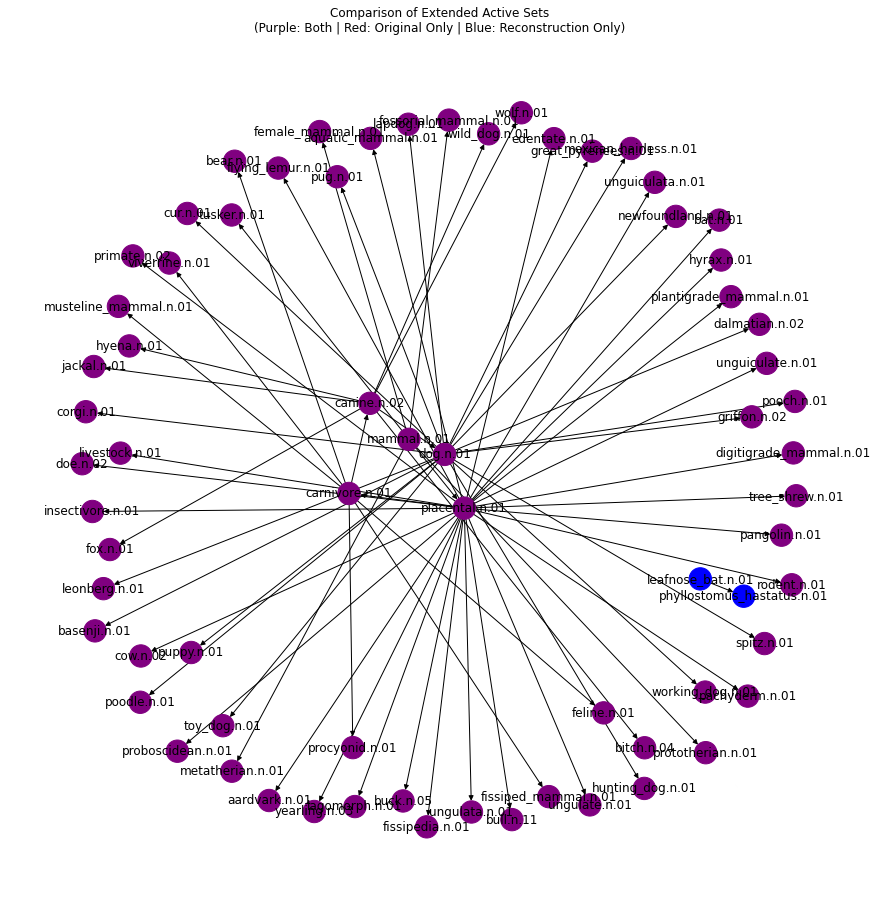

In [64]:
# Convert the extended active sets into sets of node names
extended_original_names = {syn.name() for syn in extended_active_original}
extended_recon_names = {syn.name() for syn in extended_active_recon}

# Compute the union of both sets – nodes active in either the original or reconstructed sample
active_union = extended_original_names.union(extended_recon_names)

# Create a subgraph that contains only nodes present in the active union
H = G.subgraph(active_union).copy()

# Set colors for each node in the subgraph H:
# Purple for nodes active in both sets,
# Red if only in the original,
# Blue if only in the reconstructed
node_colors = []
for node in H.nodes():
    if node in extended_original_names and node in extended_recon_names:
        node_colors.append("purple")
    elif node in extended_original_names:
        node_colors.append("red")
    elif node in extended_recon_names:
        node_colors.append("blue")

# spring layout
pos = nx.spring_layout(H)

# Draw the subgraph
plt.figure(figsize=(12, 12))
nx.draw(
    H, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=500,
    arrows=True
)
plt.title("Comparison of Extended Active Sets\n(Purple: Both | Red: Original Only | Blue: Reconstruction Only)")
plt.show()